In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67, 2], (8,8))))
end

getEdepGateBarA0 (generic function with 1 method)

In [3]:
#getEdepGateBarA0(1, 0)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
#getEdepGateBarA90(1, 40)

In [6]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [7]:
#getEdepGateGrid(1, 45)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [8]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [9]:
#getEdepOhioBarA0(1)

In [10]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [11]:
#getEdepOhioBarA90(1)

In [12]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [13]:
#normalize(getEdepOhioBarA90(1))

In [14]:
#normalize(getEdepOhioBarA0(1))

In [45]:
function makeTrainingData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i,  (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i,  (r-1)*15)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [16]:
size(filter(x->occursin("E02__W05__H05", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

24

In [17]:
size(filter(x->occursin("A000", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

500

In [46]:
function makeValidationData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    #trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    start = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingSize = 50
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i + start, (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i + start, (r-1)*15)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [19]:
#makeValidationData()

In [47]:
function makeTargetData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [21]:
#makeTargetData()

In [48]:
function makeValTargetData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingSize = 100
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    #trainingSize = 100
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i + start, (r-1)*15)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [23]:
#makeValTargetData()

In [24]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize)
    
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [25]:
#makeInputData()

In [49]:
trainingArray = makeTrainingData()

8×8×2×7200 Array{Int64, 4}:
[:, :, 1, 1] =
 2  3   2  379  382   3  0  0
 0  2   2  304  404   2  2  0
 2  2   5  320  341   2  0  0
 2  1  23  399  375   3  4  0
 1  3   6  369  484   7  1  0
 0  2   2  374  469   4  1  2
 1  1   3  253  421   4  1  2
 1  0  29  156  193  20  3  1

[:, :, 2, 1] =
 1   3  20  462  306   2  1  1
 0   5  21  517  295   2  1  1
 0   1   2  557  406   2  1  0
 1   0   5  497  517   2  4  1
 0   0  11  421  390   4  2  2
 1   2  35  334  254   2  3  0
 1   0  27  339  417  11  0  1
 1  31   1  218  239  20  0  1

[:, :, 1, 2] =
  0  4  13  300  300   6  2  2
  1  1   4  429  344   5  1  0
  2  3   3  398  331  20  4  2
  2  2  35  536  321   2  1  1
  3  1  20  577  450   3  1  2
  1  2   5  406  504   2  1  3
  0  1   1  393  333   3  3  0
 35  2   1  126  155  11  1  0

[:, :, 2, 2] =
 2   3   5  430  380  18  1  1
 2   2   7  449  366   3  3  0
 2   1   3  472  407   8  4  1
 2   2   4  409  423   5  3  2
 1   3   4  314  350   5  1  0
 0   2  10  386  3

In [50]:
targetArray = makeTargetData()

512×7200 Matrix{Int64}:
 0  0  0  1  0  0  0  0  0  0  0  0  0  …  0  0  0   7  0   0   0  0  0  2  0
 1  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0   0  0   0   0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0   4  0   0   0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0   0  0   2   1  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0   0  0   5   0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0   0  0   5   0  0  0  0  0
 0  0  1  1  0  0  0  0  0  0  0  1  0     0  0  0   0  0   3   0  0  0  0  1
 0  0  1  0  2  0  0  0  0  0  1  0  0     0  0  0   0  0   0   0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1     0  0  7   9  0   0   0  1  0  4  6
 0  1  0  0  1  0  0  0  0  0  0  0  0     0  0  7   2  0   0   0  0  0  2  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  …  0  0  2   0  0   0   0  0  4  5  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0   0  2   0   3  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  

In [51]:
validationArray = makeValidationData()

8×8×2×900 Array{Int64, 4}:
[:, :, 1, 1] =
  0  45  260  1823  1473  195  36   0
 19  43  244  1687  1596  263  14   1
  0   5  107  1312  1586  194   2   0
 21  34   86  1109  1340  115   3   0
  0   1   75   940  1176  144  25   0
  0   1   18   705   846   39   0   0
  0  17   56   495   608   18   0  11
  0   2   13   159   196    1   1  10

[:, :, 2, 1] =
 2  26  236  1561  1461  222  62  15
 2  16  305  1589  1524  220  35   9
 0  42  178  1527  1535  213  20   1
 0  12   90  1212  1257  105  11   2
 0  26   55   976   988  136   8   0
 0   5   39   729   809   90   6   0
 0   3   31   509   518   35   8   3
 0   6   28   175   181    0  10   0

[:, :, 1, 2] =
  1  11  127  1644  1440  221  31  13
  0   6  197  1495  1286  184  24   0
  0  17  247  1368  1204  213  26   0
  6  37   91  1223  1172  106   9   0
 10   0   57  1017  1084   18  10   1
  7   1   15   676   784    5  19   0
  6   2    1   396   508   15   4   0
  4   4    0   134   157    6   1   1

[:, :, 2, 2] =
  0  3

In [52]:
validationTargetArray = makeValTargetData()

LoadError: UndefVarError: start not defined

In [30]:
inputArray = makeInputData()

8×8×2×21 Array{Int64, 4}:
[:, :, 1, 1] =
 38484  42128  52850  126117  208366  54216  42413  38391
 39382  44555  47446  118228  285328  61556  41870  39128
 36595  39956  55851  189571  294911  57231  42411  38908
 38021  43502  45917  122588  483994  71271  40778  39157
 40115  46611  55757  176140  345909  74524  42913  39929
 39228  38664  58439  162217  244550  68536  43572  39139
 37466  37933  56898  131986  361086  60613  48624  37953
 35604  38155  43116   84692  184161  70698  43053  37902

[:, :, 2, 1] =
 19404  22059  44432  101296   77978  36257  21430  19332
 20006  24228  42568   87020  105097  53825  21343  20054
 17905  20826  56275  160868  105372  47073  21694  19664
 19379  23974  36643   91733  144345  65212  20635  20134
 20977  26756  56546  140444  126791  68834  22822  20629
 20002  20012  61299  128934   87739  61529  22612  20076
 18627  19083  62967   99105  119800  47310  25929  19225
 17006  19348  31036   58054   65617  59364  22150  18946

[:, :, 1, 2] =

In [31]:
function plotResults(m)
    image = rand((1: size(trainingArray)[2]))
    print(image)
    display(heatmap(reshape(Int64.(round.(m(validationArray)))[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(Int64.(round.(m(inputArray)))[:,1], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [53]:
m = Chain(Conv((2,2), 2=>16, pad=(1,1), relu),
        x -> reshape(x, :, size(x,4)), 

        Dense(1296, 850),
        Dense(850, 8*8*8),
        x -> abs.(x))

Chain(Conv((2, 2), 2=>16, relu), #57, Dense(1296, 850), Dense(850, 512), #58)

In [41]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM()
dataset = (repeated((trainingArray, targetArray), 50))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

Training R2: 0.0007783651497824673
Validation R2: 0.00024348274187202534


loss(trainingArray, targetArray) = 6733.4556f0
loss(trainingArray, targetArray) = 2392.244f0
loss(trainingArray, targetArray) = 1710.9105f0
loss(trainingArray, targetArray) = 1463.3541f0
loss(trainingArray, targetArray) = 1301.3911f0
loss(trainingArray, targetArray) = 1246.6228f0
loss(trainingArray, targetArray) = 1191.5938f0


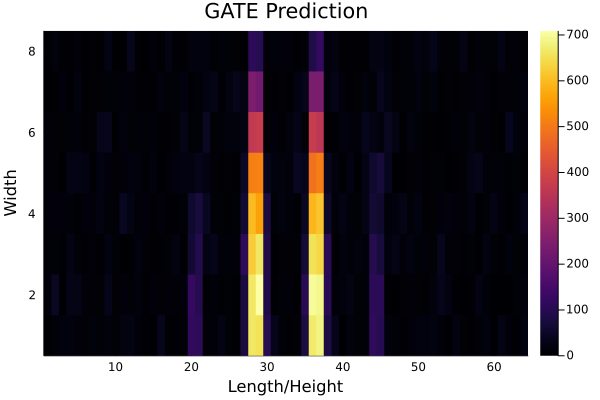

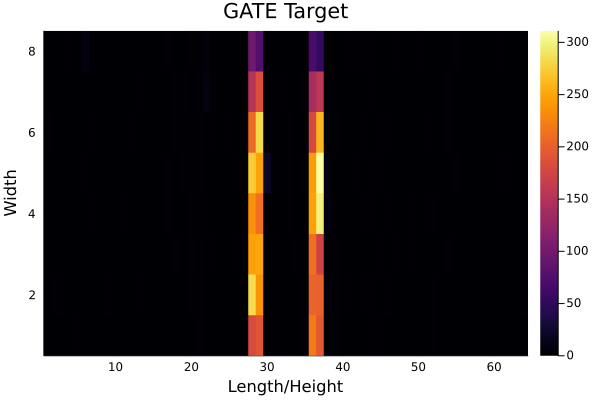

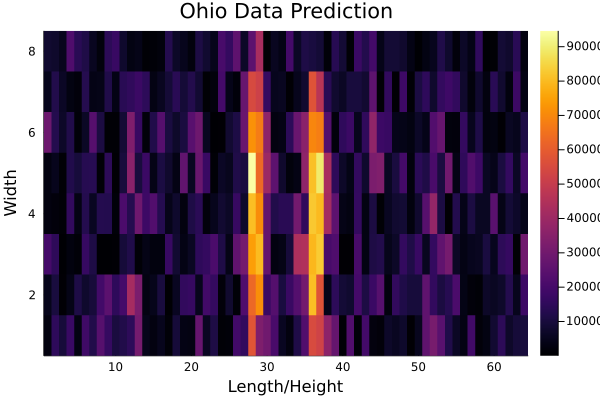

Training R2: 0.8837283789497563
Validation R2: 0.8041659850107599

	2loss(trainingArray, targetArray) = 1175.664f0
loss(trainingArray, targetArray) = 1149.5587f0
loss(trainingArray, targetArray) = 1132.7799f0
loss(trainingArray, targetArray) = 1120.5768f0
loss(trainingArray, targetArray) = 1108.3333f0
loss(trainingArray, targetArray) = 1097.7476f0
loss(trainingArray, targetArray) = 1088.8672f0


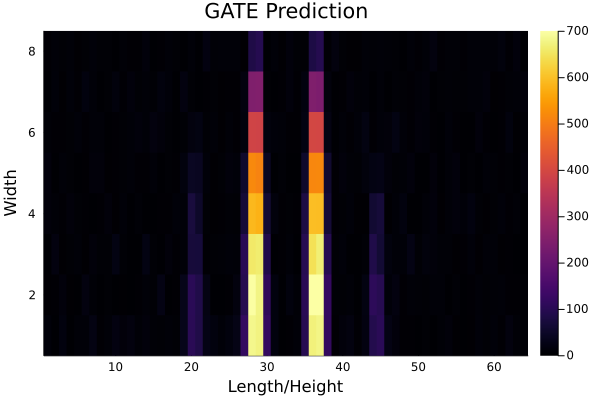

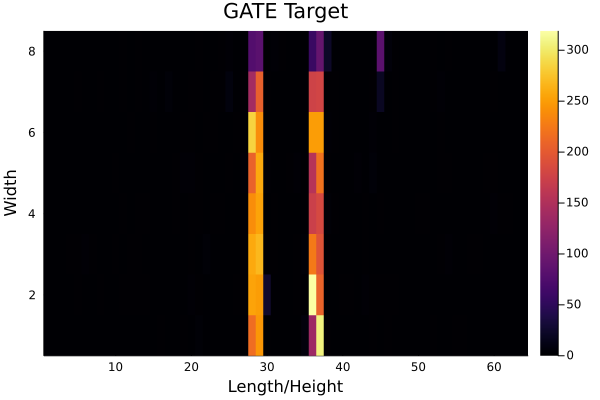

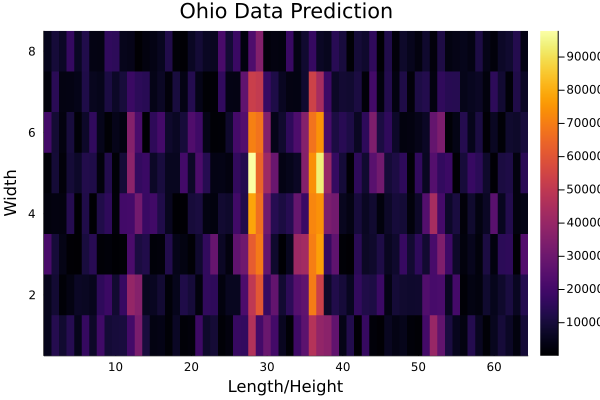

Training R2: 0.9015774151392786
Validation R2: 0.8068190614288768

	7loss(trainingArray, targetArray) = 1083.8556f0
loss(trainingArray, targetArray) = 1074.8788f0
loss(trainingArray, targetArray) = 1064.8811f0
loss(trainingArray, targetArray) = 1057.2037f0
loss(trainingArray, targetArray) = 1049.6367f0
loss(trainingArray, targetArray) = 1043.7512f0
loss(trainingArray, targetArray) = 1038.278f0


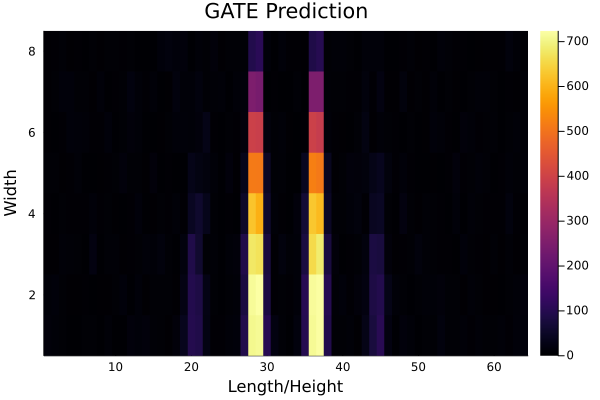

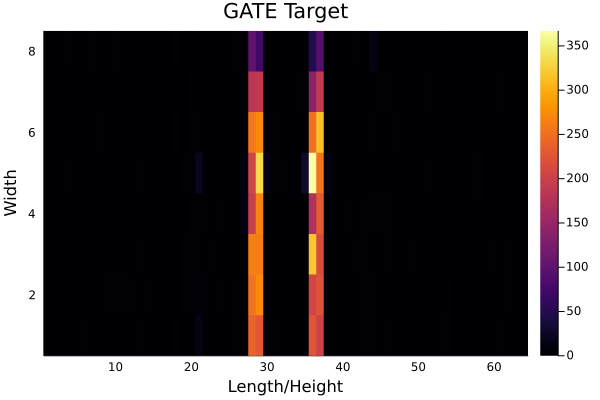

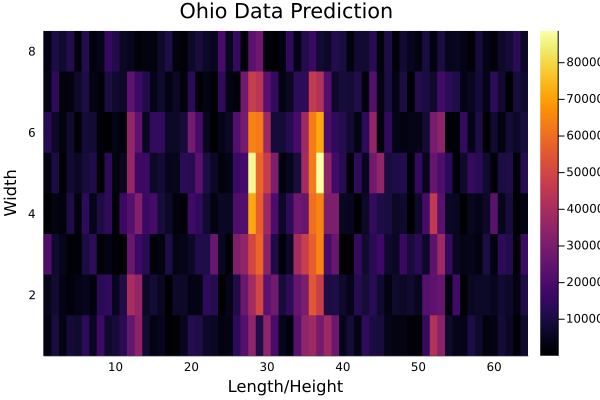

Training R2: 0.908476540919273
Validation R2: 0.8074006561141702

	5loss(trainingArray, targetArray) = 1033.9934f0
loss(trainingArray, targetArray) = 1029.3195f0
loss(trainingArray, targetArray) = 1024.4498f0
loss(trainingArray, targetArray) = 1019.8719f0
loss(trainingArray, targetArray) = 1015.48627f0
loss(trainingArray, targetArray) = 1011.4795f0
loss(trainingArray, targetArray) = 1007.9382f0


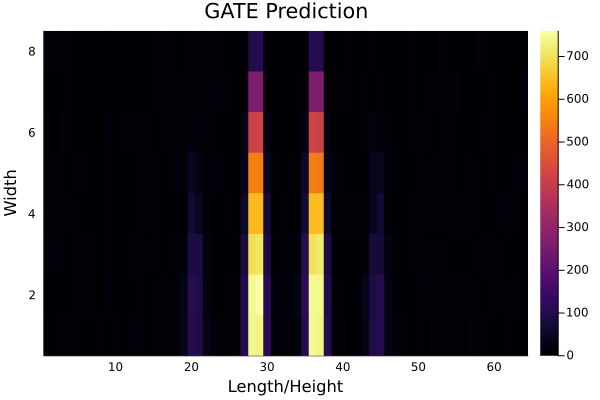

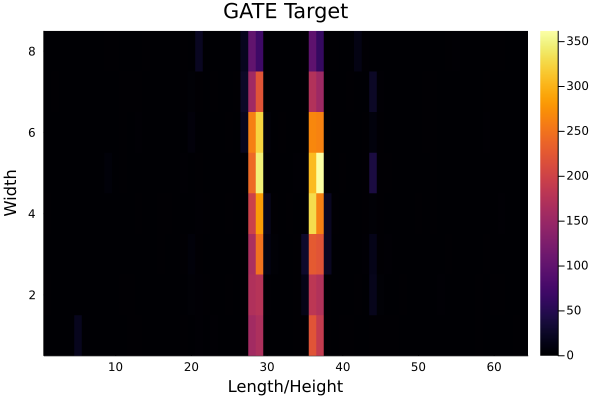

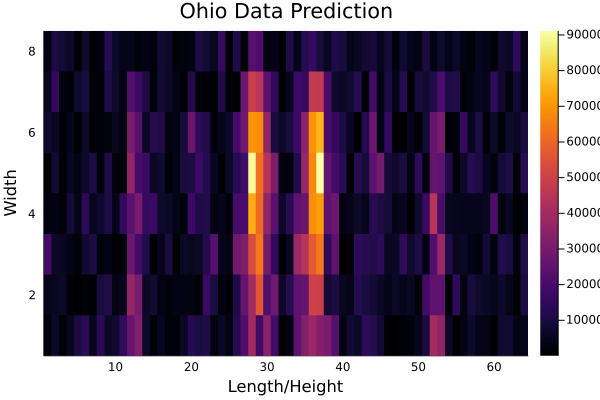

Training R2: 0.9097189460468025
Validation R2: 0.8089424143163587

	1loss(trainingArray, targetArray) = 1006.74536f0
loss(trainingArray, targetArray) = 1003.5894f0
loss(trainingArray, targetArray) = 1000.65875f0
loss(trainingArray, targetArray) = 998.304f0
loss(trainingArray, targetArray) = 995.9577f0
loss(trainingArray, targetArray) = 993.55414f0
loss(trainingArray, targetArray) = 991.6861f0


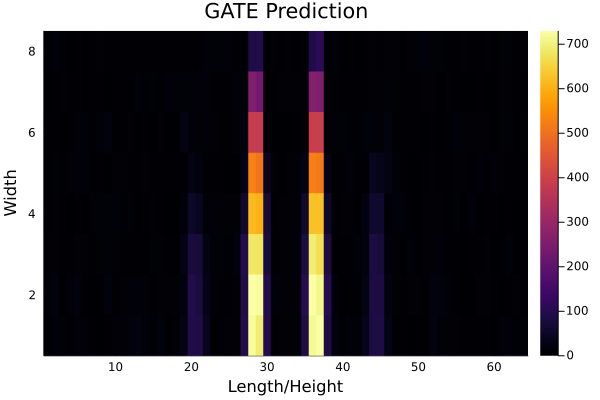

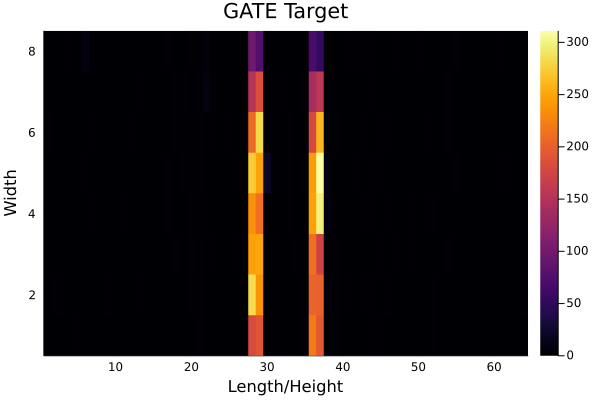

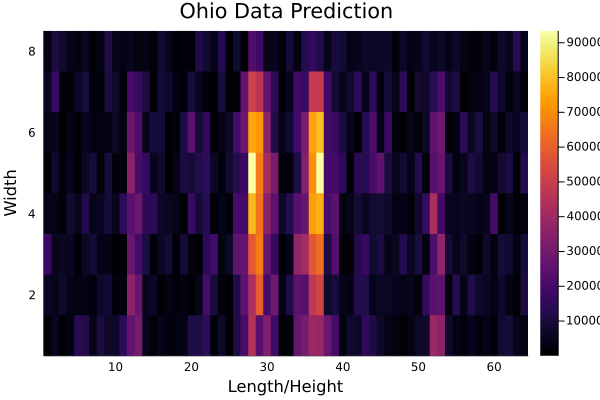

Training R2: 0.9142530542033304
Validation R2: 0.8081134882624592

	2loss(trainingArray, targetArray) = 990.7098f0
loss(trainingArray, targetArray) = 989.0545f0
loss(trainingArray, targetArray) = 987.3271f0
loss(trainingArray, targetArray) = 985.727f0
loss(trainingArray, targetArray) = 984.3236f0
loss(trainingArray, targetArray) = 982.84406f0
loss(trainingArray, targetArray) = 981.52246f0


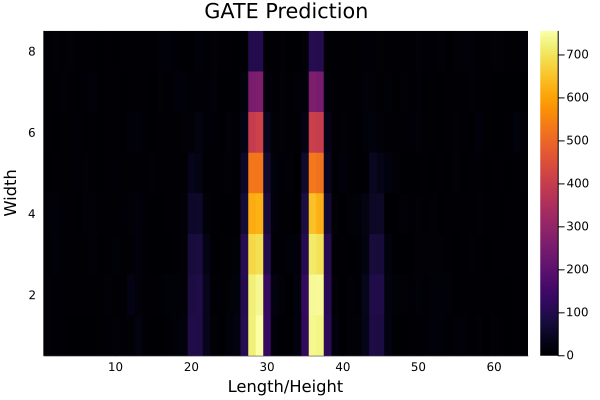

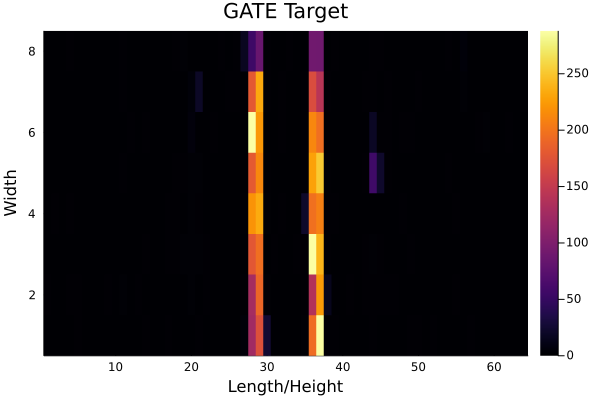

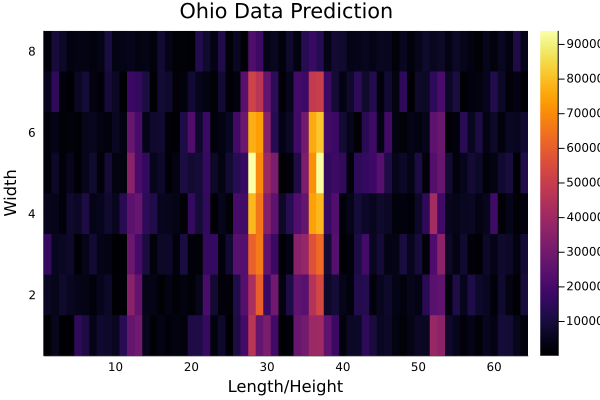

Training R2: 0.9150514730601526
Validation R2: 0.806640091956742

	6loss(trainingArray, targetArray) = 980.81946f0
loss(trainingArray, targetArray) = 980.21826f0
loss(trainingArray, targetArray) = 978.5625f0
loss(trainingArray, targetArray) = 977.4758f0
loss(trainingArray, targetArray) = 976.42035f0
loss(trainingArray, targetArray) = 975.4886f0
loss(trainingArray, targetArray) = 974.61774f0


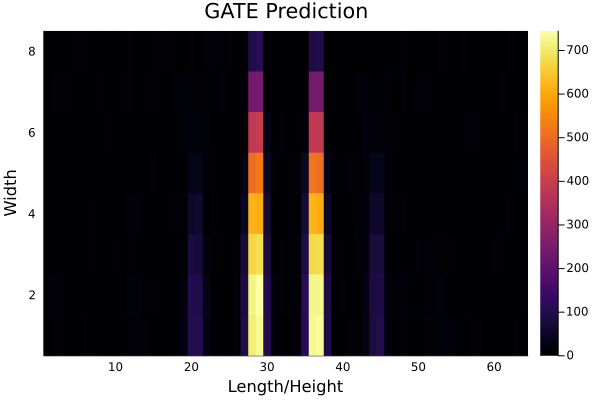

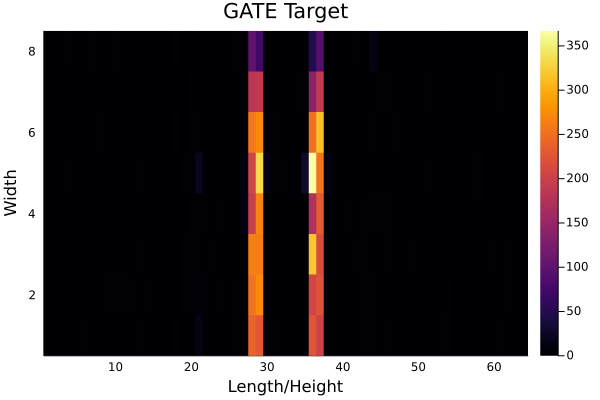

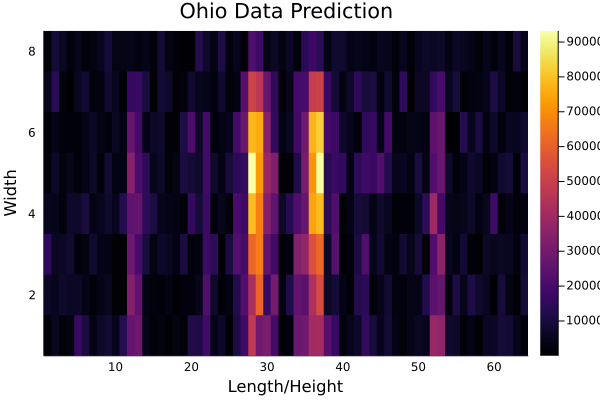

Training R2: 0.9142575013707939
Validation R2: 0.8049185903916858

	5loss(trainingArray, targetArray) = 973.78687f0
loss(trainingArray, targetArray) = 973.0024f0
loss(trainingArray, targetArray) = 972.0706f0
loss(trainingArray, targetArray) = 971.5867f0
loss(trainingArray, targetArray) = 970.4456f0
loss(trainingArray, targetArray) = 969.5405f0
loss(trainingArray, targetArray) = 968.78796f0


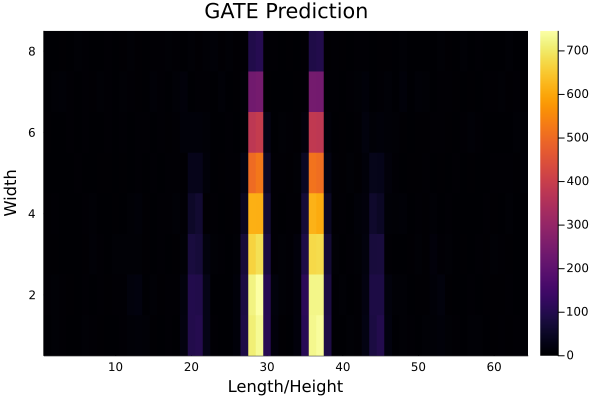

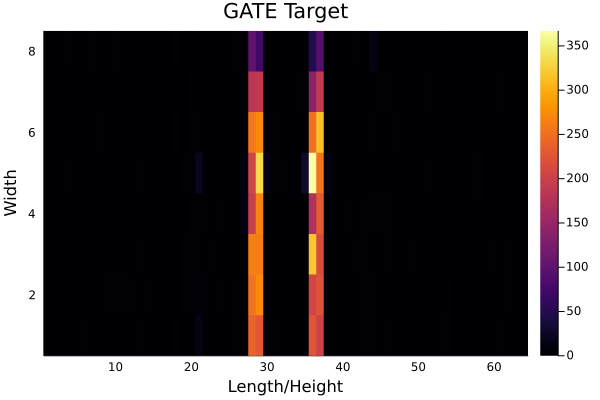

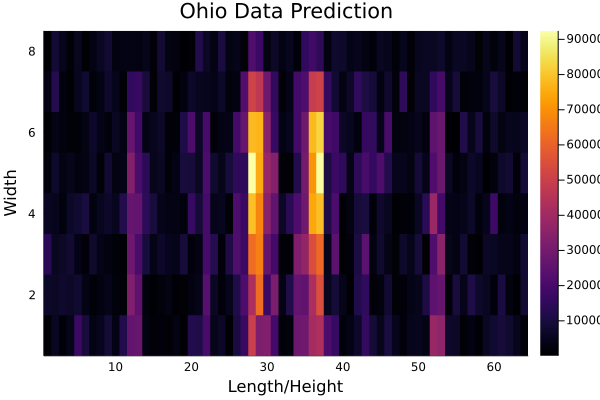

Training R2: 0.91311383994654
Validation R2: 0.8037587075520161

	5loss(trainingArray, targetArray) = 968.5234f0
loss(trainingArray, targetArray) = 967.8161f0
loss(trainingArray, targetArray) = 967.1804f0
loss(trainingArray, targetArray) = 966.54645f0
loss(trainingArray, targetArray) = 966.9854f0
loss(trainingArray, targetArray) = 965.3094f0
loss(trainingArray, targetArray) = 964.64545f0


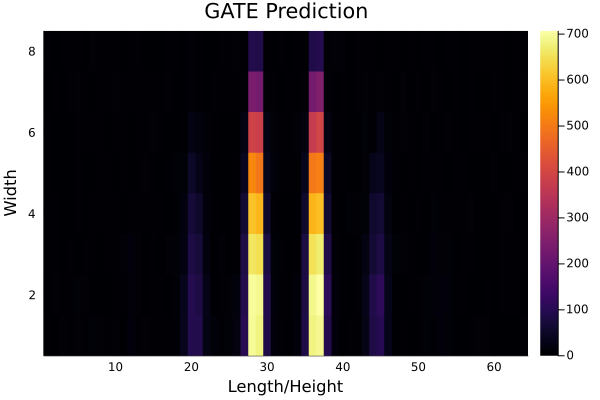

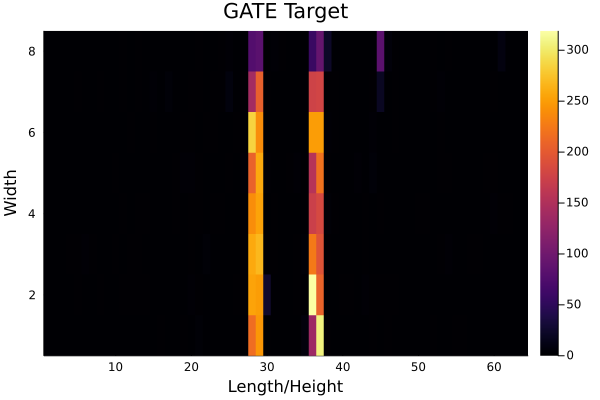

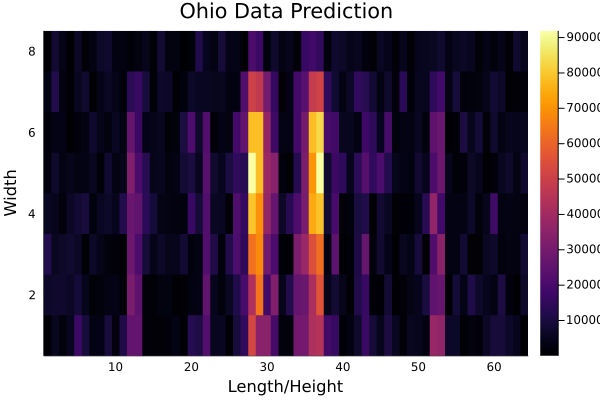

Training R2: 0.912479663092721
Validation R2: 0.8013997561330848

	7loss(trainingArray, targetArray) = 964.365f0
loss(trainingArray, targetArray) = 963.81885f0
loss(trainingArray, targetArray) = 963.4185f0
loss(trainingArray, targetArray) = 962.78973f0
loss(trainingArray, targetArray) = 962.4511f0
loss(trainingArray, targetArray) = 963.1368f0
loss(trainingArray, targetArray) = 961.93805f0
loss(trainingArray, targetArray) = 961.18835f0


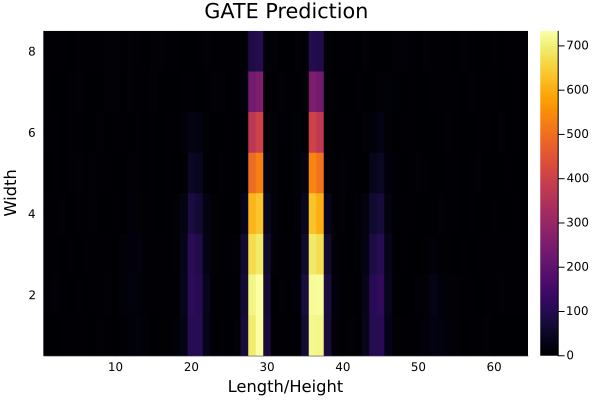

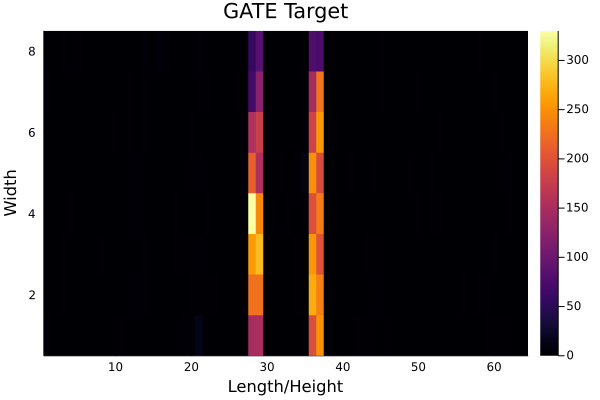

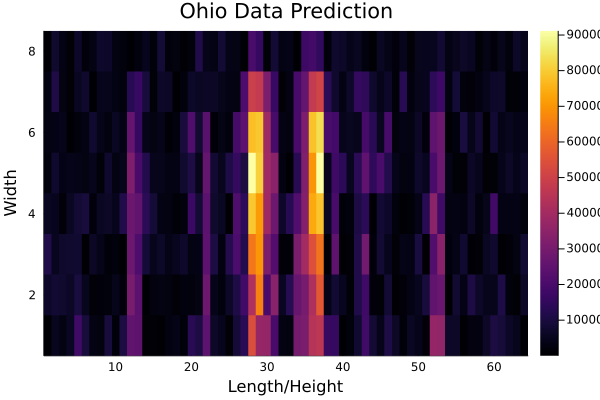

Training R2: 0.9110199688145729
Validation R2: 0.8006521688048609

	4

In [54]:
for i = 1:10
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 5))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
end

In [55]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/NathanRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
            
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(100-1, div(size(validationTargetArray)[2],readSize))+1][1:8]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), Int.(round.(reshape(m(validationArray)[:,i], (8*8,8)))), " ")
    end


    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [56]:
writeOutput(m)

LoadError: BoundsError: attempt to access 512×900 Matrix{Float32} at index [1:512, 901]